<a href="https://colab.research.google.com/github/dajebbar/FreeCodeCamp-python-data-analysis/blob/main/Overfit_generalization_underfit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Overfit-generalization-underfit
---

We will put these two errors (training and testing errors) into perspective and show how they can help us know if our model generalizes, overfits, or underfits.

Let's first load the data and create the model.

In [1]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
data, target = housing.data, housing.target
target *= 100  # rescale the target in k$

In [2]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor()

Overfitting vs. underfitting
To better understand the generalization performance of our model and maybe find insights on how to improve it, we will compare the testing error with the training error. Thus, we need to compute the error on the training set, which is possible using the `cross_validate` function.

In [5]:
import pandas as pd
from sklearn.model_selection import cross_validate, KFold

cv = KFold(n_splits=10, shuffle=True, random_state=42)
cv_results = cross_validate(regressor,
                            data,
                            target,
                            scoring='neg_mean_absolute_percentage_error',
                            return_train_score=True, 
                            n_jobs=2,
                            )
cv_results = pd.DataFrame(cv_results)
cv_results[['train_error', 'test_error']] = -cv_results[['train_score','test_score']]
cv_results.head()

,fit_time,score_time,test_score,train_score,train_error,test_error
0,0.307118,0.004160,-0.443029,-6.795584e-18,6.795584e-18,0.443029
1,0.319030,0.004977,-0.281443,-6.506410e-18,6.506410e-18,0.281443
2,0.288021,0.004439,-0.309689,-2.953704e-17,2.953704e-17,0.309689
3,0.314271,0.004316,-0.387510,-7.718186e-18,7.718186e-18,0.387510
4,0.220471,0.003016,-0.307164,-1.804582e-17,1.804582e-17,0.307164


In [6]:
scores = cv_results[['train_error', 'test_error']]
scores.head()

,train_error,test_error
0,6.795584e-18,0.443029
1,6.506410e-18,0.281443
2,2.953704e-17,0.309689
3,7.718186e-18,0.387510
4,1.804582e-17,0.307164


Text(0.5, 1.0, 'Train and test errors distribution via cross-validation')

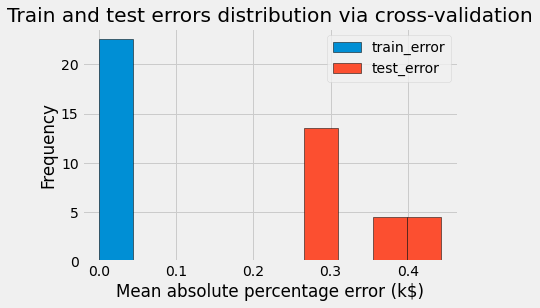

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns 
plt.style.use('fivethirtyeight')

scores.plot.hist(bins=10, edgecolor="black", density=True)
plt.xlabel("Mean absolute percentage error (k$)")
plt.title("Train and test errors distribution via cross-validation")

By plotting the distribution of the training and testing errors, we get information about whether our model is over-fitting, under-fitting (or both at the same time).

Here, we observe a small training error (actually zero), meaning that the model is not under-fitting: it is flexible enough to capture any variations present in the training set.

Courbe de validation
Certains hyperparamètres de modèle sont généralement la clé pour passer d'un modèle sous-ajusté à un modèle surajusté, en espérant traverser une région où nous pouvons obtenir un bon équilibre entre les deux. On peut acquérir des connaissances en traçant une courbe appelée courbe de validation. Cette courbe peut également être appliquée à l'expérience ci-dessus et fait varier la valeur d'un hyperparamètre.

Pour l'arbre de décision, le paramètre `max_depth` est utilisé pour contrôler le compromis entre le sous-ajustement et le sur-ajustement.

In [17]:
%%time
from sklearn.model_selection import validation_curve

max_depth = list(range(1, 26, 5))
train_scores, test_scores = validation_curve(regressor, 
                                             data, 
                                             target, 
                                             cv=cv, 
                                             scoring='neg_mean_absolute_percentage_error',
                                             param_name='max_depth', 
                                             param_range=max_depth,
                                             n_jobs=2,
)

train_scores, test_scores = -train_scores, -test_scores

CPU times: user 375 ms, sys: 54.5 ms, total: 430 ms
Wall time: 8.72 s


Now that we collected the results, we will show the validation curve by plotting the training and testing errors (as well as their deviations).

Text(0.5, 1.0, 'Validation curve for decision tree')

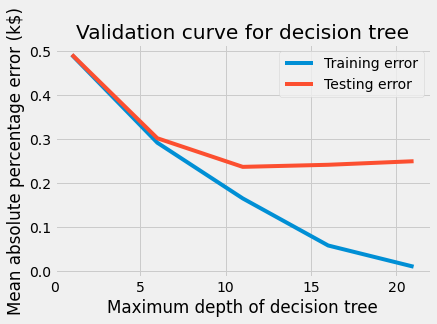

In [18]:
plt.plot(max_depth, train_scores.mean(axis=1), label='Training error')
plt.plot(max_depth, test_scores.mean(axis=1), label='Testing error')
plt.legend()

plt.xlabel("Maximum depth of decision tree")
plt.ylabel("Mean absolute percentage error (k$)")
plt.title("Validation curve for decision tree")

The validation curve can be divided into three areas:

For `max_depth < 10`, the decision tree underfits. The training error and therefore the testing error are both high. The model is too constrained and cannot capture much of the variability of the target variable.

The region around `max_depth = 10` corresponds to the parameter for which the decision tree generalizes the best. It is flexible enough to capture a fraction of the variability of the target that generalizes, while not memorizing all of the noise in the target.

For `max_depth > 10`, the decision tree overfits. The training error becomes very small, while the testing error increases. In this region, the models create decisions specifically for noisy samples harming its ability to generalize to test data.  

Note that for `max_depth = 10`, the model overfits a bit as there is a gap between the training error and the testing error. It can also potentially underfit also a bit at the same time, because the training error is still far from zero (more than 30 k$), meaning that the model might still be too constrained to model interesting parts of the data. However, the testing error is minimal, and this is what really matters. This is the best compromise we could reach by just tuning this parameter.

Be aware that looking at the mean errors is quite limiting. We should also look at the standard deviation to assess the dispersion of the score. We can repeat the same plot as before but this time, we will add some information to show the standard deviation of the errors as well.

Text(0.5, 1.0, 'Validation curve for decision tree')

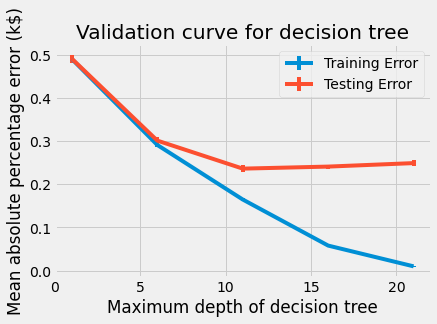

In [19]:
plt.errorbar(max_depth, 
             train_scores.mean(axis=1), 
             yerr=train_scores.std(axis=1), 
             label='Training Error')
plt.errorbar(max_depth,
             test_scores.mean(axis=1),
             yerr=test_scores.std(axis=1),
             label='Testing Error')

plt.legend()

plt.xlabel("Maximum depth of decision tree")
plt.ylabel("Mean absolute percentage error (k$)")
plt.title("Validation curve for decision tree")

We were lucky that the variance of the errors was small compared to their respective values, and therefore the conclusions above are quite clear. This is not necessarily always the case.

---
# Effect of the sample size in cross-validation
---

We presented the general cross-validation framework and how to assess if a predictive model is underfiting, overfitting, or generalizing. Besides these aspects, it is also important to understand how the different errors are influenced by the number of samples available.

We will show this aspect by looking at the variability of the different errors.

To understand the impact of the number of samples available for training on the generalization performance of a predictive model, it is possible to synthetically reduce the number of samples used to train the predictive model and check the training and testing errors.

Therefore, we can vary the number of samples in the training set and repeat the experiment. The training and testing scores can be plotted similarly to the validation curve, but instead of varying a hyperparameter, we vary the number of training samples. This curve is called the **learning curve**.

It gives information regarding the benefit of adding new training samples to improve a model's generalization performance.

Let's compute the learning curve for a decision tree and vary the proportion of the training set from 10% to 100%.

In [21]:
import numpy as np
train_sizes = np.linspace(0.1, 1.0, num=5, endpoint=True)
train_sizes

array([0.1  , 0.325, 0.55 , 0.775, 1.   ])

We will use a `ShuffleSplit` cross-validation to assess our predictive model.

In [22]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=30, test_size=.2)

Now, we are all set to carry out the experiment.

In [23]:
from sklearn.model_selection import learning_curve

results = learning_curve(
    regressor,
    data,
    target,
    cv=cv,
    train_sizes=train_sizes,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=2,
)

In [25]:
train_sizes, train_scores, test_scores = results[:3]
# Convert the scores into errors
train_errors, test_errors = -train_scores, -test_scores

Now, we can plot the curve.

Text(0.5, 1.0, 'Learning curve for decision tree')

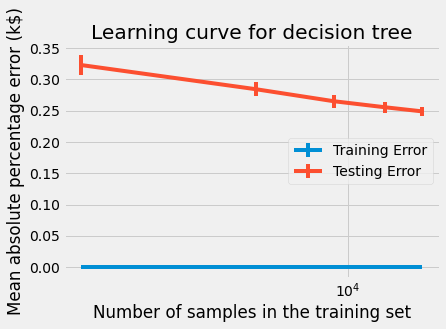

In [28]:
plt.errorbar(train_sizes,
              train_errors.mean(axis=1),
              yerr=train_errors.std(axis=1),
              label='Training Error')

plt.errorbar(train_sizes,
             test_errors.mean(axis=1),
             yerr=test_errors.std(axis=1),
             label='Testing Error')

plt.legend()


plt.xscale("log")
plt.xlabel("Number of samples in the training set")
plt.ylabel("Mean absolute percentage error (k$)")
plt.title("Learning curve for decision tree")

Looking at the training error alone, we see that we get an error of 0 k$. It means that the trained model (i.e. decision tree) is clearly overfitting the training data.

Looking at the testing error alone, we observe that the more samples are added into the training set, the lower the testing error becomes. Also, we are searching for the plateau of the testing error for which there is no benefit to adding samples anymore or assessing the potential gain of adding more samples into the training set.

If we achieve a plateau and adding new samples in the training set does not reduce the testing error, we might have reach the Bayes error rate using the available model. Using a more complex model might be the only possibility to reduce the testing error further.